In [1]:
#@title Load utility functions
import numpy as np

def unique(vec):
    seen = set()
    seen_add = seen.add
    return [v for v in vec if not (v in seen or seen_add(v))]

def is_aa_one_nat(sequence, additional=""):
  additional = additional.upper()
  for aa in sequence.upper():
    if not (aa in "ACDEFGHIKLMNPQRSTVWY" or aa in additional):
      return(False)
    return(True)

def read_fasta(filename, comment_char="#;"):
    """Flexible FASTA file reader without dependencies"""
    seq_list = []
    file_id = filename.split("/")[-1].split(".")[0]
    reading_fasta = False
    with open(filename,"r") as file_handle:
        for line in file_handle:
            words = line.split()
            if len(words) == 0:
                continue
            if words[0][0] in comment_char:
                continue
            if words[0][0] == ">":
                if reading_fasta:
                    seq_list.append((seq_id,seq))
                seq_id = words[0][1:]
                seq = ""
                reading_fasta = True
            elif reading_fasta:
                if len(words) > 1:
                    print("WARNING: Found FASTA line with more white space separated fields:\n%s" % (line))
                seq = seq + words[0]
            else:
                if len(words) == 1:
                    seq = words[0]
                    if not is_aa_one_nat(seq):
                        print("ERROR: Non-FASTA single-column file should have a protein sequence in first column:")
                        print(line)
                        return(None)
                    seq_id = file_id+"%05d" % (len(seq_list))
                    seq_list.append((seq_id,seq))
                elif len(words) > 1:
                    seq = words[1]
                    if not is_aa_one_nat(seq):
                        print("ERROR: Non-FASTA multi-column file should have a protein sequence in second column:")
                        print(line)
                        return(None)
                    seq_list.append((words[0],seq))
        if reading_fasta:
            seq_list.append((seq_id,seq))
    return(seq_list)

def tile_sequence(seq, tile_len, tile_offset=1, add_ct_tile=True):
  """Cut sequence into tiles of length tile_len"""
  nres = len(seq)
  tile_begin = 0
  tile_end = tile_len
  tile_list = []
  while(tile_end <= nres):
    tile_list.append(seq[tile_begin:tile_end])
    tile_begin = tile_begin + tile_offset
    tile_end = tile_begin + tile_len
  if tile_end !=  nres+1 and add_ct_tile:
    tile_list.append(seq[-tile_len:])
  return(tile_list)

# Trained on WT data with >50 raw counts total in 4 the bins                                                                                                                        
# Peptides classified degrons if PSI<2.2 and stable if PSI>2.8                                                                                                                      
# Parameter are per amino acid counts in peptides of length 17                                                                                                                      
model = {}
model["intersect"] = -0.89102423
model["C"] =   0.37721431
model["D"] =  -0.78986558
model["E"] =  -0.65124014
model["K"] =  -0.15518666
model["R"] =  -0.02030300
model["H"] =  -0.02110156
model["N"] =  -0.32782161
model["Q"] =  -0.17676485
model["A"] =   0.10844211
model["G"] =  -0.37594135
model["S"] =  -0.09627044
model["T"] =  -0.08533912
model["V"] =   0.43746326
model["M"] =   0.31182498
model["L"] =   0.53427787
model["I"] =   0.61465146
model["F"] =   0.52882600
model["Y"] =   0.45253658
model["W"] =   0.58693535
model["P"] =  -0.25880796

def calc_degron_prob(seq_list):
  p_list = []
  for seq in seq_list:
    # This model is only valid for peptides of length 17                                                                                                                        
    assert len(seq) == 17
    lin = model["intersect"] + sum([model[aa] for aa in seq])
    responce = 1/(1+np.exp(-lin))
    p_list.append(responce)
  return(p_list)


In [28]:
from google.colab import files

#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
#@markdown Input one or more white space separated amino acid sequences 

sequence_input = 'CALLQSRLLLSAPRRAAATARY' #@param {type:"string"}

#@markdown and/or upload a FASTA file (check box and click run).

Upload_FASTA_file = False #@param {type:"boolean"}

seq_list = []

# Read text input
if sequence_input != "":
  sequences = sequence_input.upper().strip().split()
  for sequence in sequences:
    seq_up = sequence.upper()
    if len(sequence) < 17:
      print("WARNING: Sequence '%s' is shorter than 17 amino acid and ignored" % 
            (sequence))
    elif not is_aa_one_nat(seq_up):
      print("WARNING: Sequence '%s' is not a canonical amino acid sequence and ignored" % 
            (sequence))
    else:
      seq_list.append(("seq%05d" % (len(seq_list)), seq_up))
  print("Got %d sequences from text input" % (len(seq_list)))

# Read file input
if Upload_FASTA_file:
  uploaded = files.upload()
  for filename in uploaded.keys():
    # bug: if the same name.fa is uploaded, this will write name (1).fa 
    # but not update filename variable so the old file will be loaded!
    print("Read %s" % (filename))
    for (seq_id,seq_aa) in read_fasta(filename):
      if len(seq_aa) < 17:
        print("WARNING: Sequence %s %s from file %s is shorter than 17 amino acids and ignored" % 
              (seq_id,seq_aa,filename))
      else:
        seq_list.append((seq_id,seq_aa.upper()))

if len(seq_list) > 0:
  print("Got %d sequences from input" % (len(seq_list)))
  
  # check names
  seq_ids = [v[0] for v in seq_list]
  if len(seq_ids) != len(set(seq_ids)):
    print("WARNING: Sequence names used to identify tiles are not unique")
  
  # Tile sequences and calculate degron probability
  result = []
  for (seq_id,seq) in seq_list:
    tile_seq = tile_sequence(seq, 17, 1)
    tile_degron_prob = calc_degron_prob(tile_seq)
    # assign degron probability to central amino acid
    resi = 9
    for i in range(len(tile_seq)):
      result.append([seq_id, tile_seq[i], tile_degron_prob[i], tile_seq[i][8], resi])
      # print("%18s  %17s  %.5f  %1s  %4d" % 
      #       (seq_id, tile_seq[i], tile_degron_prob[i], tile_seq[i][8], resi))
      resi += 1
else:
  print("No input")

Got 1 sequences from text input
Got 1 sequences from input


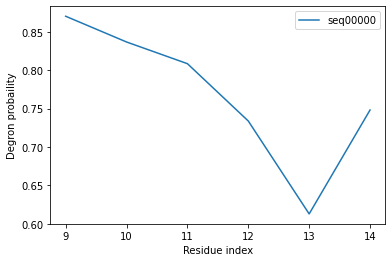

In [29]:
import matplotlib.pyplot as plt

#@title Plot degron probabilities for a protein
#@markdown Give the index or name of a protein to plot

index_or_name = '0' #@param {type:"string"}

seq_names = [v[0] for v in result]
seq_names_uniq = unique(seq_names)
name2plot = None

try:
  plot_index = int(index_or_name)
  assert plot_index <= len(seq_names_uniq)
  name2plot = seq_names_uniq[plot_index]
except:
  name2plot = index_or_name

if name2plot in seq_names_uniq:
  plot_index = np.where(np.array(seq_names) == name2plot)[0]
  result_np = np.array(result)
  resi = [int(v[4]) for v in result_np[plot_index] ]
  if (len(resi) != len(set(resi))):
    print("WARNING: More points for same residue index - are sequence names unique?")
  deg_prob = [float(v[2]) for v in result_np[plot_index] ]
  plt.plot(resi, deg_prob, label=name2plot)
  plt.plot()

  plt.xlabel("Residue index")
  plt.ylabel("Degron probaility")
  # plt.title("Line Graph Example")
  plt.legend()
  plt.show()
else:
  print("Cannot plot sequence \'%s\'" % (name2plot))


In [30]:
#@title Download results
#@markdown If this fails, try googles chorme browser
filename = 'QCDpred.txt' #@param {type:"string"}
write_header = True #@param {type:"boolean"}

if len(result) > 0:
  with open(filename, 'w') as f:
    if write_header:
      # white space separated text
      f.write("%-20s  %17s  %8s  %2s  %4s\n" % 
              ("name","sequence","deg_prob","aa","resi"))
      
      # ecxel style csv
      # f.write("name;sequence;deg_prob;aa;resi")
    for line in result:
      # white space separated text
      f.write("%-20s  %17s  %8.5f  %2s  %4d\n" % tuple(line))

      # quoted strings
      # f.write("%-20s  %17s  %8.5f  %2s  %4d\n" % 
      #        ("\""+line[0]+"\"", "\""+line[1]+"\"", line[2], "\""+line[3]+"\"", line[4]))
      
      # ecxel style csv
      # f.write("%s;%s;%.5f;%s;%d\n" % tuple(line))
  files.download(filename)
else:
  print("No result to download")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>